Problem statement: Melanoma, a type of skin cancer, is responsible for 75% of skin cancer deaths and can be fatal if not detected early. Dermatologists often rely on manual inspection of skin lesions, which can be time-consuming and prone to human error. To address this issue, the aim of this project is to develop a deep learning model based on convolutional neural networks (CNN) that can accurately detect melanoma from skin lesion images. The model will be trained on a large dataset of annotated skin lesion images and evaluated using performance metrics such as sensitivity, specificity, and accuracy. The final solution will be an automated system that can evaluate skin lesion images and alert dermatologists about the presence of melanoma, potentially reducing the manual effort needed for diagnosis and improving early detection rates.

# Importing the input data from ISIC on skin cancer
## To do: Execute necessary actions to read the data
### Importing all the important libraries

In [28]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
     


In [29]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Beginning Keras Processing

## Loading images off disk using image_dataset_from_directory utility.

In [30]:
# Defining the path for train and test images
data_inp_train = pathlib.Path('/content/drive/MyDrive/CNN_Assignment/Train')
data_inp_test = pathlib.Path('/content/drive/MyDrive/CNN_Assignment/Test')

# Count in dataset

In [31]:
image_count_train = len(list(data_inp_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_inp_test.glob('*/*.jpg')))
print(image_count_test)

2249
118


## Define parameters for the loader:

In [32]:
batch_size = 32
img_height = 180
img_width = 180

### Allocating 80% images for training and 20%  for testing

In [33]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_inp_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    label_mode='categorical',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2249 files belonging to 9 classes.
Using 1800 files for training.


In [34]:
# Test dataset
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_inp_test,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    label_mode='categorical',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [35]:
# List out all the classes of skin cancer and store them in a list. 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


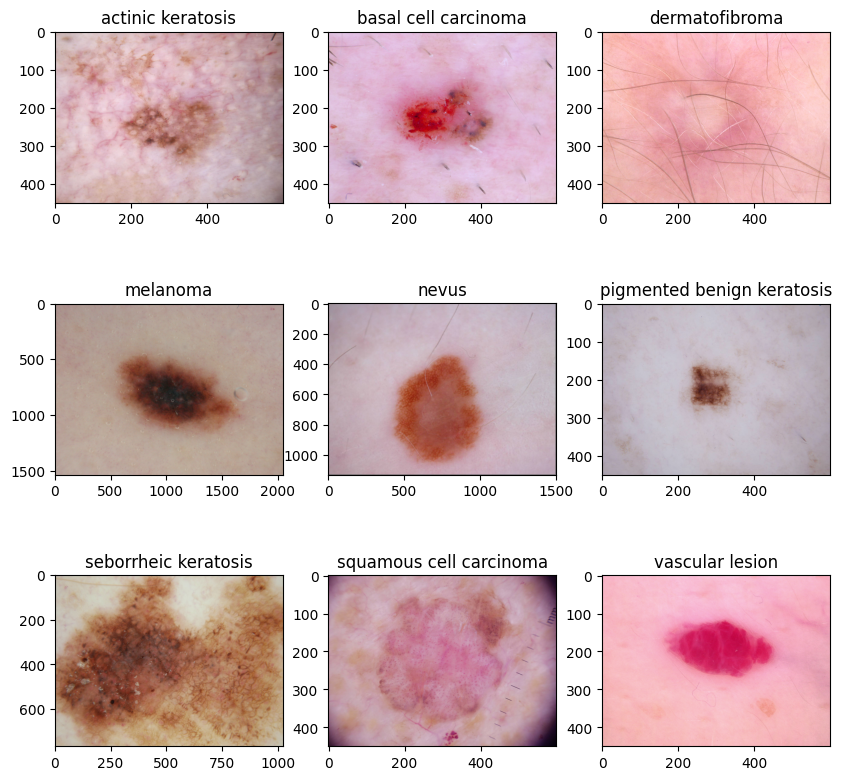

In [36]:
# Visualize the data
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_inp_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

In [37]:
# using autotune for better transfer learning
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [38]:
# CNN model building
model=Sequential()

#rescalling 
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 30% Fraction of the input units to drop.
model.add(layers.Dropout(0.30))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))


# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

In [39]:
# optimiser and loss function
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [40]:
# lets run it for 20 epochs 
epochs = 20
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/20
57/57 [==============================] - 22s 94ms/step - loss: 1.9416 - accuracy: 0.2811 - val_loss: 2.2451 - val_accuracy: 0.1304
Epoch 2/20
57/57 [==============================] - 3s 49ms/step - loss: 1.7115 - accuracy: 0.3761 - val_loss: 2.3862 - val_accuracy: 0.2174
Epoch 3/20
57/57 [==============================] - 3s 56ms/step - loss: 1.5871 - accuracy: 0.4272 - val_loss: 2.1765 - val_accuracy: 0.3043
Epoch 4/20
57/57 [==============================] - 3s 49ms/step - loss: 1.4662 - accuracy: 0.4900 - val_loss: 2.3958 - val_accuracy: 0.3043
Epoch 5/20
57/57 [==============================] - 3s 48ms/step - loss: 1.4015 - accuracy: 0.5022 - val_loss: 2.5706 - val_accuracy: 0.2609
Epoch 6/20
57/57 [==============================] - 3s 48ms/step - loss: 1.3265 - accuracy: 0.5300 - val_loss: 2.6203 - val_accuracy: 0.2609
Epoch 7/20
57/57 [==============================] - 3s 49ms/step - loss: 1.2697 - accuracy: 0.5461 - val_loss: 3.2420 - val_accuracy: 0.1739
Epoch 8/20
5

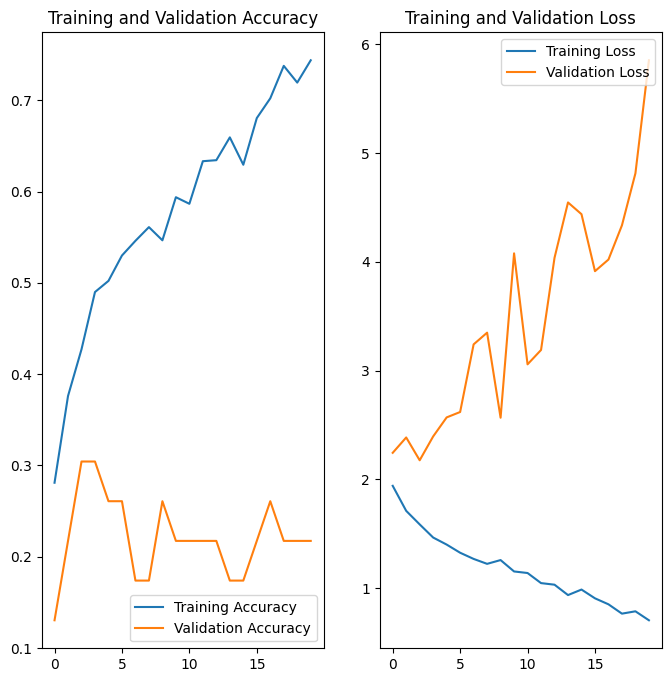

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

* The model is overfitting because we can also see difference in loss functions in training & test around the 10-11th epoch

* The accuracy is just around 75-80% because there are enough features to remember the pattern.

* But again, it's too early to comment on the overfitting & underfitting debate.

**Lets use some data augmentation strategy**

In [42]:
# data augmentation
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

In [43]:
# CNN model building
model=Sequential([data_augument,layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180,180 ,3))])

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 30% Fraction of the input units to drop.
model.add(layers.Dropout(0.30))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))


# model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                  

In [44]:
# optimiser and loss function
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [45]:
# training the model
epochs = 20
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/20
57/57 [==============================] - 5s 58ms/step - loss: 2.1015 - accuracy: 0.2294 - val_loss: 2.4586 - val_accuracy: 0.1739
Epoch 2/20
57/57 [==============================] - 3s 54ms/step - loss: 1.7884 - accuracy: 0.3594 - val_loss: 2.1727 - val_accuracy: 0.3043
Epoch 3/20
57/57 [==============================] - 3s 54ms/step - loss: 1.6287 - accuracy: 0.4228 - val_loss: 2.0929 - val_accuracy: 0.2609
Epoch 4/20
57/57 [==============================] - 3s 53ms/step - loss: 1.5557 - accuracy: 0.4456 - val_loss: 2.1563 - val_accuracy: 0.2609
Epoch 5/20
57/57 [==============================] - 3s 54ms/step - loss: 1.5413 - accuracy: 0.4572 - val_loss: 2.4558 - val_accuracy: 0.2174
Epoch 6/20
57/57 [==============================] - 3s 53ms/step - loss: 1.4682 - accuracy: 0.4989 - val_loss: 2.8631 - val_accuracy: 0.2174
Epoch 7/20
57/57 [==============================] - 3s 52ms/step - loss: 1.4476 - accuracy: 0.5022 - val_loss: 3.2690 - val_accuracy: 0.2609
Epoch 8/20
57

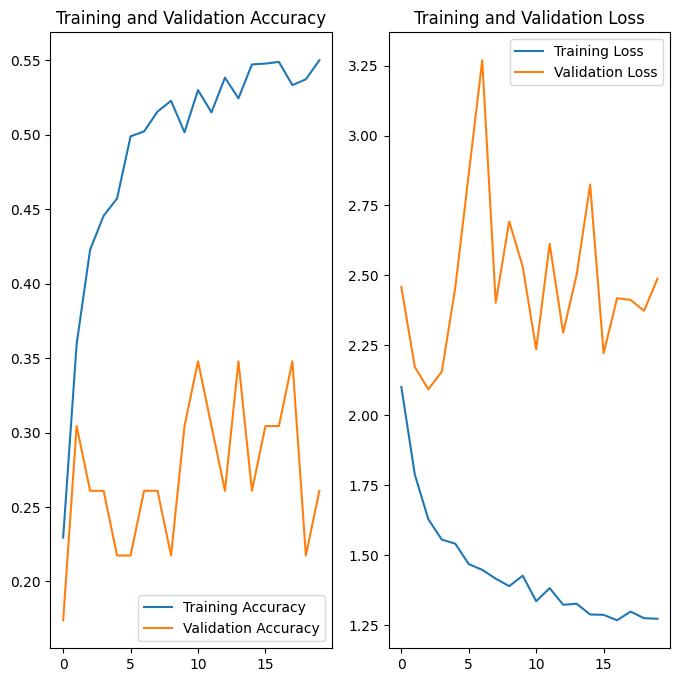

In [46]:
# lets plot our results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**We can see the performance has increased a bit and overfitting is less than the previous model**

**We can do one more thing we can see class distribution to understand the data better**

In [47]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_inp_train)
df

,Class,No. of Image
0,actinic keratosis,114
1,basal cell carcinoma,376
2,vascular lesion,139
3,pigmented benign keratosis,463
4,melanoma,438
5,nevus,366
6,squamous cell carcinoma,181
7,dermatofibroma,95
8,seborrheic keratosis,77


**From the count in above display, we can confirm the data has class imbalance and that needs to be treated**

**We can try to solve by using augmentor library**

<Axes: xlabel='No. of Image', ylabel='Class'>

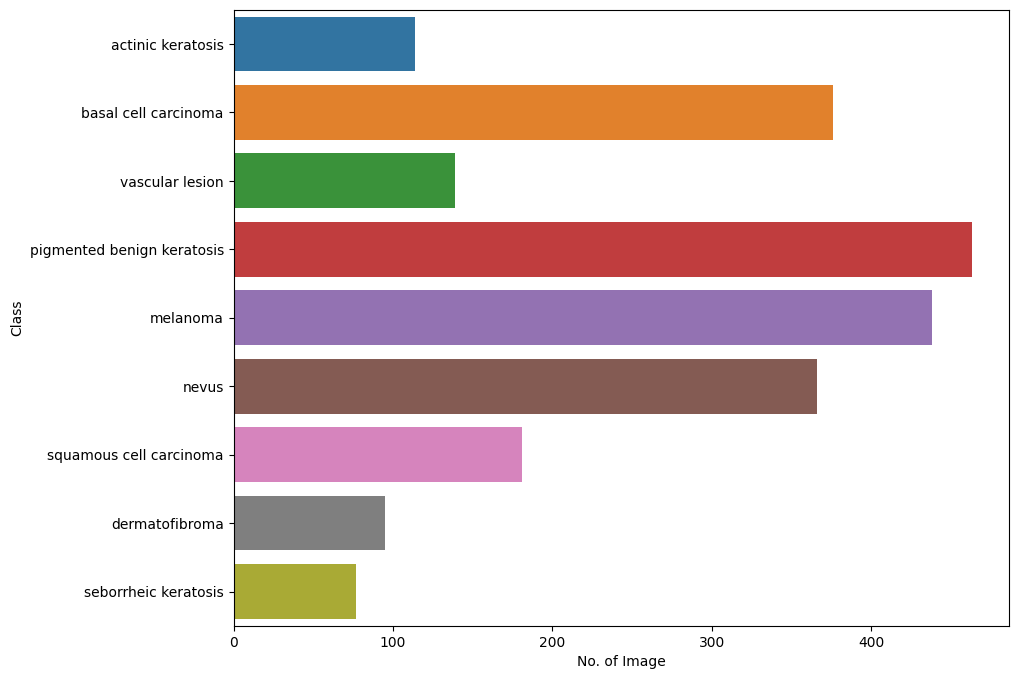

In [48]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

# Handling Class Imbalance by Augmentation

In [49]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline("/content/drive/MyDrive/CNN_Assignment/Train",save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 2249 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F0F9F61BD90>: 100%|██████████| 500/500 [00:57<00:00,  8.75 Samples/s]


Initialised with 2249 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0F9FF2A980>: 100%|██████████| 500/500 [00:53<00:00,  9.43 Samples/s]


Initialised with 2249 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0F9FF76440>: 100%|██████████| 500/500 [00:51<00:00,  9.76 Samples/s]


Initialised with 2249 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F0FA80CA860>: 100%|██████████| 500/500 [00:51<00:00,  9.64 Samples/s]


Initialised with 2249 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0F9FF6E260>: 100%|██████████| 500/500 [00:53<00:00,  9.28 Samples/s]


Initialised with 2249 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7F0F9FF74310>: 100%|██████████| 500/500 [00:56<00:00,  8.90 Samples/s]


Initialised with 2249 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Train/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F0FA80C9420>: 100%|██████████| 500/500 [00:56<00:00,  8.93 Samples/s]


Initialised with 2249 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Train/output.

Processing <PIL.Image.Image image mode=RGB size=576x768 at 0x7F0F9FF6FF70>: 100%|██████████| 500/500 [00:43<00:00, 11.59 Samples/s]


Initialised with 2249 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0FA80A5540>: 100%|██████████| 500/500 [00:49<00:00, 10.17 Samples/s]


In [51]:
# Saving augmented result in output_dir
output_dir = pathlib.Path('/content/drive/MyDrive/CNN_Assignment/Train/output')

In [52]:
# Count number of images we have generated
image_count_train = len(list(output_dir.glob('*/*.jpg')))
print(image_count_train)

4500


In [53]:
# Creating train dataset with the augmented data
train_ds_new = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


In [54]:
# Creating test dataset with the augmented data
val_ds_new = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


In [55]:
# Exexuting autotune for optimizing the input pipeline in our ML model
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [56]:
#Building new CNN Model with Augmented data

#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 128)      

In [57]:
#Optimiser and Loss function
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [58]:
epochs = 30
history = model.fit(train_ds_new,validation_data=val_ds_new,epochs=epochs)

Epoch 1/30
113/113 [==============================] - 24s 182ms/step - loss: 1.7726 - accuracy: 0.3508 - val_loss: 1.6562 - val_accuracy: 0.4244
Epoch 2/30
113/113 [==============================] - 19s 164ms/step - loss: 1.4841 - accuracy: 0.4825 - val_loss: 1.4119 - val_accuracy: 0.5111
Epoch 3/30
113/113 [==============================] - 21s 177ms/step - loss: 1.3532 - accuracy: 0.5289 - val_loss: 1.2674 - val_accuracy: 0.5289
Epoch 4/30
113/113 [==============================] - 21s 180ms/step - loss: 1.2486 - accuracy: 0.5661 - val_loss: 1.1937 - val_accuracy: 0.5644
Epoch 5/30
113/113 [==============================] - 21s 175ms/step - loss: 1.1648 - accuracy: 0.5836 - val_loss: 1.2295 - val_accuracy: 0.5611
Epoch 6/30
113/113 [==============================] - 19s 163ms/step - loss: 1.1417 - accuracy: 0.6081 - val_loss: 1.0782 - val_accuracy: 0.6056
Epoch 7/30
113/113 [==============================] - 21s 178ms/step - loss: 1.0291 - accuracy: 0.6356 - val_loss: 1.1210 - val_ac

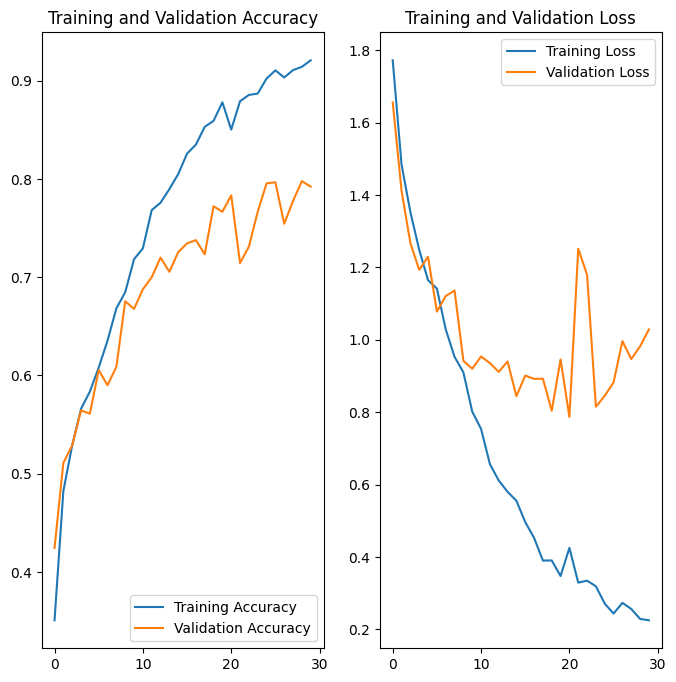

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**After treating the data for class impabalance we can predict better now due to which our model accuracy has increased to 89%**

**Also the valdation loss has further decreased**

### Due to slight overfitting in model parameters, adding L2 regularizer and Dropout of 20% after every layer. 

In [61]:
from keras.regularizers import l2

#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model_3 = Sequential()

model_3.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model_3.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model_3.add(layers.MaxPool2D(pool_size=(2,2)))
model_3.add(layers.Dropout(0.2))

#Second Convulation Layer
model_3.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model_3.add(layers.MaxPool2D(pool_size=(2,2)))
model_3.add(layers.Dropout(0.2))

#Third Convulation Layer
model_3.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model_3.add(layers.MaxPool2D(pool_size=(2,2)))
model_3.add(layers.Dropout(0.2))

model_3.add(layers.Conv2D(256,kernel_size=(3,3),activation='relu'))
model_3.add(layers.MaxPool2D(pool_size=(2,2)))


#Dropout layer with 20% Fraction of the input units to drop.
model_3.add(layers.Dropout(0.2))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model_3.add(layers.Flatten())

#Dense Layer
model_3.add(layers.Dense(256,activation='relu',kernel_regularizer=l2(0.001)))

#Dropout layer with 25% Fraction of the input units to drop.
model_3.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model_3.add(layers.Dense(len(class_names),activation='softmax'))

model_3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 89, 89, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                 

In [62]:
#optimiser and loss function
model_3.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [64]:
epochs = 30
history = model_3.fit(train_ds_new,validation_data=val_ds_new,epochs=epochs)

Epoch 1/30
113/113 [==============================] - 19s 164ms/step - loss: 1.3947 - accuracy: 0.5303 - val_loss: 1.3369 - val_accuracy: 0.5278
Epoch 2/30
113/113 [==============================] - 20s 166ms/step - loss: 1.3423 - accuracy: 0.5450 - val_loss: 1.3789 - val_accuracy: 0.5089
Epoch 3/30
113/113 [==============================] - 19s 163ms/step - loss: 1.3213 - accuracy: 0.5556 - val_loss: 1.3351 - val_accuracy: 0.5522
Epoch 4/30
113/113 [==============================] - 21s 169ms/step - loss: 1.3055 - accuracy: 0.5683 - val_loss: 1.3806 - val_accuracy: 0.5189
Epoch 5/30
113/113 [==============================] - 20s 164ms/step - loss: 1.2956 - accuracy: 0.5669 - val_loss: 1.2985 - val_accuracy: 0.5678
Epoch 6/30
113/113 [==============================] - 19s 162ms/step - loss: 1.2706 - accuracy: 0.5833 - val_loss: 1.3232 - val_accuracy: 0.5578
Epoch 7/30
113/113 [==============================] - 21s 170ms/step - loss: 1.2278 - accuracy: 0.5964 - val_loss: 1.2110 - val_ac

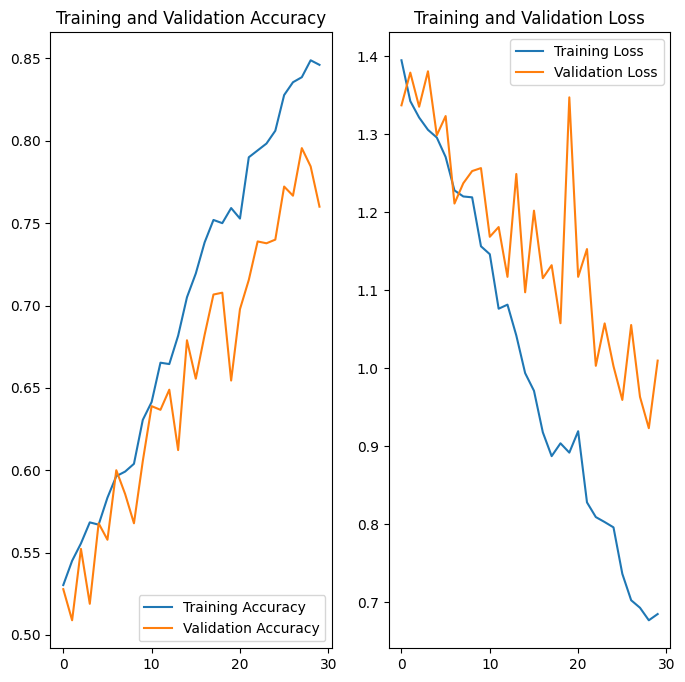

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#### Accuracy has increased and also the validation loss has reduced. So the changes made are good.

### Lets see what happens if we increase the dropout layer in our model

In [66]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model_4 = Sequential()

model_4.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model_4.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model_4.add(layers.MaxPool2D(pool_size=(2,2)))
model_4.add(layers.Dropout(0.18))

#Second Convulation Layer
model_4.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model_4.add(layers.MaxPool2D(pool_size=(2,2)))
model_4.add(layers.Dropout(0.18))

#Third Convulation Layer
model_4.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model_4.add(layers.MaxPool2D(pool_size=(2,2)))
model_4.add(layers.Dropout(0.18))

model_4.add(layers.Conv2D(256,kernel_size=(3,3),activation='relu'))
model_4.add(layers.MaxPool2D(pool_size=(2,2)))


#Dropout layer with 20% Fraction of the input units to drop.
model_4.add(layers.Dropout(0.18))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model_4.add(layers.Flatten())

#Dense Layer
model_4.add(layers.Dense(256,activation='relu',kernel_regularizer=l2(0.001)))

#Dropout layer with 22% Fraction of the input units to drop.
model_4.add(layers.Dropout(0.22))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model_4.add(layers.Dense(len(class_names),activation='softmax'))

model_4.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 89, 89, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                 

In [67]:
#optimiser and loss function
model_4.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [68]:
epochs = 20
history = model_4.fit(train_ds_new,validation_data=val_ds_new,epochs=epochs)

Epoch 1/20
113/113 [==============================] - 22s 166ms/step - loss: 2.1456 - accuracy: 0.2919 - val_loss: 1.9577 - val_accuracy: 0.3222
Epoch 2/20
113/113 [==============================] - 21s 177ms/step - loss: 1.7190 - accuracy: 0.4047 - val_loss: 1.7341 - val_accuracy: 0.4033
Epoch 3/20
113/113 [==============================] - 21s 175ms/step - loss: 1.6082 - accuracy: 0.4367 - val_loss: 1.4788 - val_accuracy: 0.4822
Epoch 4/20
113/113 [==============================] - 19s 163ms/step - loss: 1.4948 - accuracy: 0.4828 - val_loss: 1.4652 - val_accuracy: 0.5011
Epoch 5/20
113/113 [==============================] - 21s 178ms/step - loss: 1.4499 - accuracy: 0.5067 - val_loss: 1.5024 - val_accuracy: 0.4744
Epoch 6/20
113/113 [==============================] - 19s 164ms/step - loss: 1.4090 - accuracy: 0.5336 - val_loss: 1.4192 - val_accuracy: 0.5000
Epoch 7/20
113/113 [==============================] - 20s 172ms/step - loss: 1.3566 - accuracy: 0.5378 - val_loss: 1.3605 - val_ac

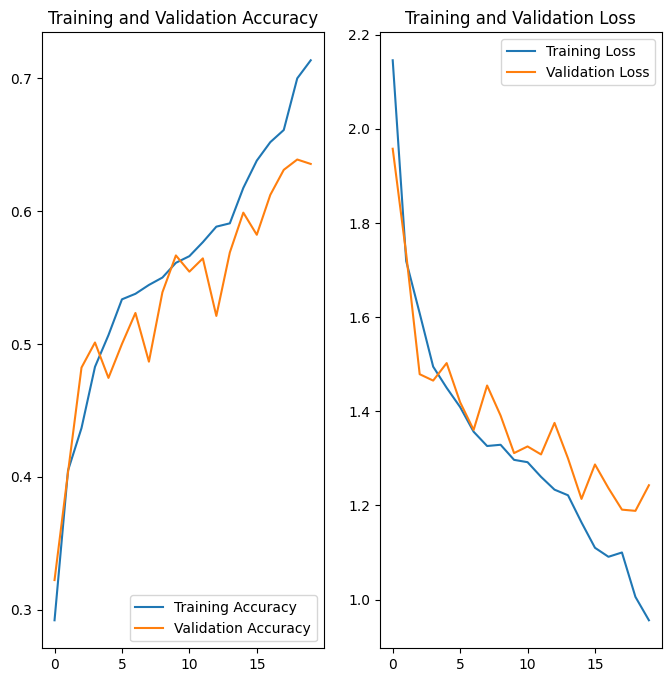

In [69]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Add one more convolutional layer to check if our model parameter inproves.

In [70]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model_5 = Sequential()

model_5.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model_5.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model_5.add(layers.MaxPool2D(pool_size=(2,2)))
model_5.add(layers.Dropout(0.15))

#Second Convulation Layer
model_5.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model_5.add(layers.MaxPool2D(pool_size=(2,2)))
model_5.add(layers.Dropout(0.15))

#Third Convulation Layer
model_5.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model_5.add(layers.MaxPool2D(pool_size=(2,2)))
model_5.add(layers.Dropout(0.15))

# Fourth Convulation Layer
model_5.add(layers.Conv2D(256,kernel_size=(3,3),activation='relu'))
model_5.add(layers.MaxPool2D(pool_size=(2,2)))
model_5.add(layers.Dropout(0.15))

# Fifth Convulation Layer
model_5.add(layers.Conv2D(512,kernel_size=(3,3),activation='relu'))
model_5.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 15% Fraction of the input units to drop.
model_5.add(layers.Dropout(0.15))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model_5.add(layers.Flatten())

#Dense Layer
model_5.add(layers.Dense(1024,activation='relu'))

#Dropout layer with 20% Fraction of the input units to drop.
model_5.add(layers.Dropout(0.2))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model_5.add(layers.Dense(len(class_names),activation='softmax'))

model_5.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 89, 89, 32)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                 

In [71]:
#optimiser and loss function
model_5.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [72]:
epochs = 30
history = model_5.fit(train_ds_new,validation_data=val_ds_new,epochs=epochs)

Epoch 1/30
113/113 [==============================] - 23s 169ms/step - loss: 1.9571 - accuracy: 0.2394 - val_loss: 1.7283 - val_accuracy: 0.3422
Epoch 2/30
113/113 [==============================] - 20s 168ms/step - loss: 1.6696 - accuracy: 0.3619 - val_loss: 1.6541 - val_accuracy: 0.3856
Epoch 3/30
113/113 [==============================] - 21s 170ms/step - loss: 1.5378 - accuracy: 0.4397 - val_loss: 1.6173 - val_accuracy: 0.4411
Epoch 4/30
113/113 [==============================] - 20s 167ms/step - loss: 1.4293 - accuracy: 0.4867 - val_loss: 1.4100 - val_accuracy: 0.5011
Epoch 5/30
113/113 [==============================] - 21s 177ms/step - loss: 1.3869 - accuracy: 0.5119 - val_loss: 1.3751 - val_accuracy: 0.4956
Epoch 6/30
113/113 [==============================] - 20s 167ms/step - loss: 1.3209 - accuracy: 0.5292 - val_loss: 1.3511 - val_accuracy: 0.5244
Epoch 7/30
113/113 [==============================] - 21s 179ms/step - loss: 1.2467 - accuracy: 0.5608 - val_loss: 1.3129 - val_ac

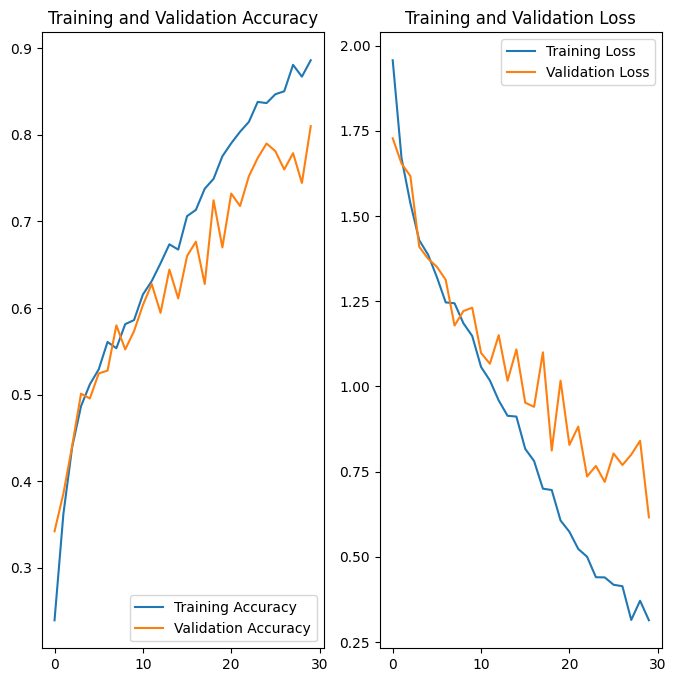

In [73]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**We can see by adding one more layer in the network we got an accurcy of around 89% which is quite good**

1/1 [==============================] - 1s 974ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


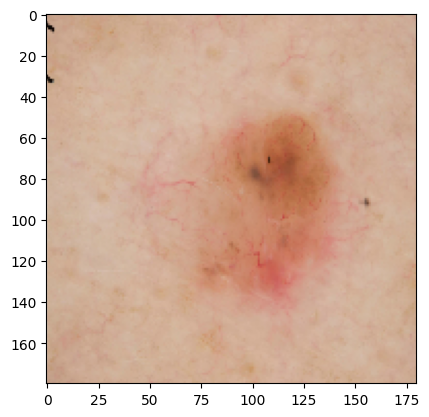

In [75]:
# Verifying how the model is perfoming on the test datset
from tensorflow.keras.preprocessing.image import load_img
from glob import glob
Test_image_path = os.path.join(data_inp_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model_5.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )

In [ ]:
### We are able to identify 9 classes of skin cancer with an accuracy of 89%